In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
data = pd.read_table('data_dir/rfm_xmas19.txt', delimiter = ',')

In [3]:
data.head()

,customer_id,trans_date,tran_amount
0,FM5295,2017-11-11,35
1,FM4768,2019-12-15,39
2,FM2122,2017-11-26,52
3,FM1217,2016-08-16,99
4,FM1850,2018-08-20,78


In [4]:
data.shape

(125000, 3)

This is the data we have the data to work with. It isn't an ideal dataset and sure we would like some more information, but given our time constraint we work with it. The columns are self explanatory. Infering from the column names, we perform an initial exploration to look for missing data. If there is a null/NA value, the Dtype of the column wouldn't be integer. It has to be object type.  

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [6]:
data[data['customer_id'] == 'FM5295']

,customer_id,trans_date,tran_amount
0,FM5295,2017-11-11,35
3556,FM5295,2019-08-25,54
4218,FM5295,2018-02-22,37
4710,FM5295,2017-09-24,36
5986,FM5295,2017-12-22,98
12777,FM5295,2017-03-03,96
13503,FM5295,2016-10-08,77
21537,FM5295,2018-07-19,53
24526,FM5295,2016-11-26,65
27655,FM5295,2019-07-02,59


- No missing values
- Transaction date is object data type
- Multiple transactions for the same customer. No unique id per say



In [7]:
data['trans_date'] = pd.to_datetime(data['trans_date'])

In [8]:
data['trans_date'].max()

Timestamp('2019-12-16 00:00:00')

Being guided by the data,
We want churned customers or customers who stopped shopping. We have a transaction date for each customer. We can shortlist them based on that. Given that most of the physical store customers buy groceries, we **assume** that a person who hasn't shopped in 2 months is a customer who churned.

Now, we will be working with different dates. But the last recorded date is 16th December 2019. Any customer whose last transaction date is prior to 2019-9-16 can be classified as churned.

In [9]:
cutoff = dt.datetime(2019,10,16)

In [10]:
customer_group = data.groupby('customer_id')
max_date_groups = customer_group['trans_date'].max()

In [11]:
cus_anal = pd.DataFrame(max_date_groups)

In [12]:
cus_anal['churn'] = 0

In [13]:
cus_anal.loc[cus_anal['trans_date'] <= cutoff, 'churn'] = 1
cus_anal.head()

,trans_date,churn
customer_id,,
FM1112,2019-10-14,1
FM1113,2019-11-09,0
FM1114,2019-11-12,0
FM1115,2019-12-05,0
FM1116,2019-05-25,1


In [14]:
cus_anal['num_of_transactions'] = customer_group.size()
cus_anal['spending_per_cus'] = customer_group['tran_amount'].sum()

In [15]:
cus_anal.head()

,trans_date,churn,num_of_transactions,spending_per_cus
customer_id,,,,
FM1112,2019-10-14,1,15,1012
FM1113,2019-11-09,0,20,1490
FM1114,2019-11-12,0,19,1432
FM1115,2019-12-05,0,22,1659
FM1116,2019-05-25,1,13,857


In [17]:
churn_counts = cus_anal['churn'].value_counts()

In [19]:
churn_counts

0    3633
1    3256
Name: churn, dtype: int64

Plot the Churned and non-churned customers.

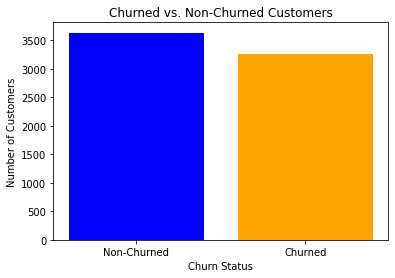

In [18]:
plt.bar(churn_counts.index, churn_counts.values, color=['blue', 'orange'])
plt.title('Churned vs. Non-Churned Customers')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks(churn_counts.index, ['Non-Churned', 'Churned'])
plt.show()

Let us now filter our data to only select those customers that are churned.
There are a few ppossible ways to allocate the 1000$ in marketing to target the churned customers. Firstly we see if there is a correlation between number of transactions and amount spend by customers.

1. Seasonal/Tourists will have < 5 transactions

In [21]:
churned_cus = cus_anal[cus_anal['churn'] == 1]
churned_cus.head()

,trans_date,churn,num_of_transactions,spending_per_cus
customer_id,,,,
FM1112,2019-10-14,1,15,1012
FM1116,2019-05-25,1,13,857
FM1117,2019-04-02,1,17,1185
FM1123,2019-08-27,1,19,1331
FM1124,2019-10-02,1,18,1127


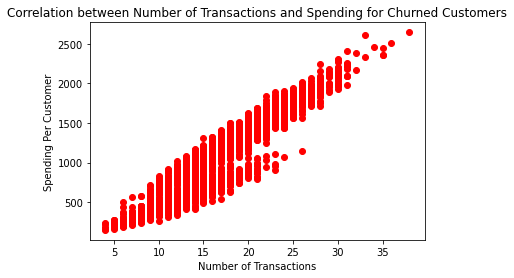

In [22]:
plt.scatter(churned_cus['num_of_transactions'], churned_cus['spending_per_cus'], color='red')
plt.title('Correlation between Number of Transactions and Spending for Churned Customers')
plt.xlabel('Number of Transactions')
plt.ylabel('Spending Per Customer')
plt.show()

In [23]:
churned_cus = churned_cus[churned_cus['num_of_transactions'] >= 5]

Since spending per customers is directly related to the number of transactions as well, we could look for the top spending customer to invest 1000$ 

But just to be safe, I compute a scaled score by weighting transactions and spending equally.